In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import tqdm
from PIL import Image
train_on_gpu = True
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

In [27]:
!pip install --upgrade pip

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\kjhgf\anaconda3\python.exe -m pip install --upgrade pip


### Data overview

In [28]:
import os

# 현재 작업 디렉토리를 가져옵니다.
data_root = os.getcwd()

# 현재 디렉토리 출력
print(data_root)

c:\github\CAPSTONE


In [29]:
#train data의 csv 파일 읽어오기
train_df = pd.read_csv(f"{data_root}/washer_train.csv")
train_df.head()

,Image,normal
0,001.jpg,1
1,002.jpg,1
2,003.jpg,1
3,004.jpg,1
4,005.jpg,1


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   399 non-null    object
 1   normal  399 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


## 데이터 압축 풀기

In [31]:
import zipfile

# 압축을 풀 폴더의 경로를 정의합니다.
dataset_folder = os.path.join(data_root, 'img_washer_train')

# 폴더가 존재하지 않는 경우 새로 생성합니다.
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# 압축을 풀 파일의 경로를 정의합니다.
zip_path = os.path.join(data_root, 'img_washer_train.zip')

# zipfile 모듈을 사용하여 파일의 압축을 풉니다.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

In [32]:
print(f"There are {len(os.listdir(f'{dataset_folder}'))} images in train dataset with {train_df.normal.nunique()} unique classes.")

There are 399 images in train dataset with 2 unique classes.


25k images in train and 5k different whales!
Let's have a look at them

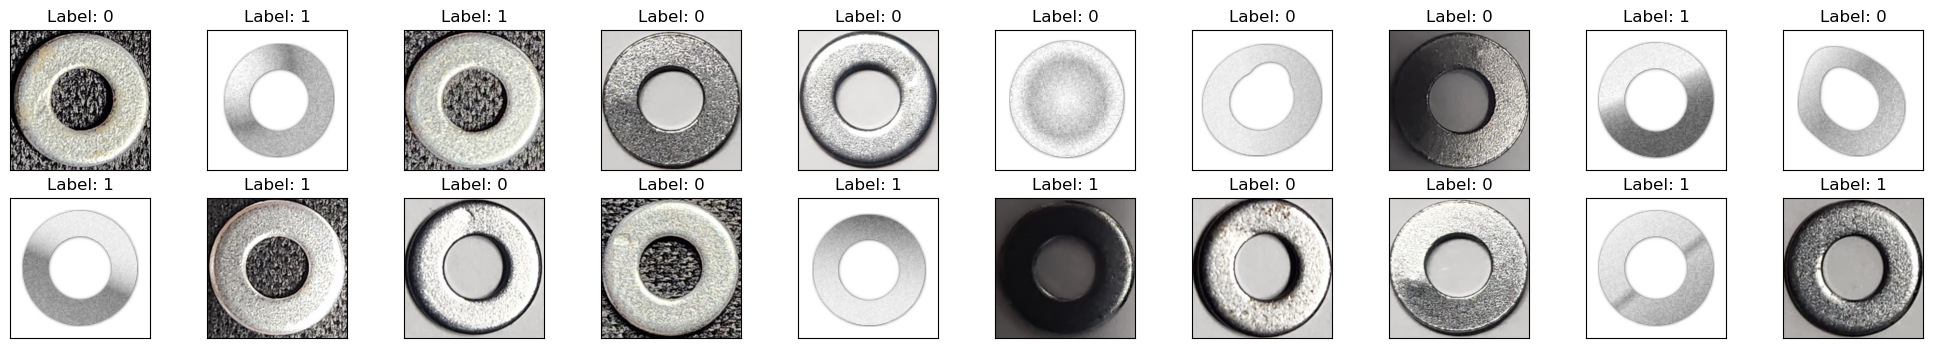

In [33]:
train_imgs = os.listdir(dataset_folder)

fig = plt.figure(figsize=(25, 4))
for idx, img in enumerate(np.random.choice(train_imgs, 20, replace=False)):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(dataset_folder, img))
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'normal'].values[0]
    ax.set_title(f'Label: {lab}')

plt.show()

In [34]:
train_df.normal.value_counts().head()

normal
0    204
1    195
Name: count, dtype: int64

학습을 위한 데이터로 만들어주자

In [35]:
np.array(im).shape

(512, 512, 3)

In [36]:
def prepare_labels(y):
    # 입력 라벨 배열을 numpy 배열로 변환
    values = np.array(y)
    
    # 라벨을 정수로 인코딩
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)

    # 정수 인코딩된 라벨을 원-핫 인코딩
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    # 원-핫 인코딩된 라벨과 라벨 인코더를 반환
    y = onehot_encoded
    #print(y.shape)
    return y, label_encoder

In [37]:
y, label_encoder = prepare_labels(train_df['normal'])

print(y[:5])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


c:\Users\kjhgf\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
y.shape

(399, 2)

In [39]:
from torchvision import transforms


mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]

# RGB 값의 평균을 계산하여 그레이스케일 채널에 사용
mean_gray = sum(mean_rgb) / len(mean_rgb)
std_gray = sum(std_rgb) / len(std_rgb)

#데이터 증강기법 transform
transform = transforms.Compose([
    transforms.Resize((128,128)),  # 이미지 크기를 128*128로 변경
    transforms.Grayscale(),       # 그레이스케일로 변환(이미 흑백이긴 하다.)
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),        # 텐서로 변환
        transforms.Normalize(mean=[mean_gray], std=[std_gray])  # 정규화
])

In [40]:
#학습 시키기 위해 CustomDataset 함수를 선언했다.
class CustomDataset(Dataset):
    def __init__(self, dataset_folder, labels, transform=None):
        self.dataset_folder = dataset_folder
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset_folder)

    def __getitem__(self, idx):
        image_path = self.dataset_folder[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [41]:
image_paths = [os.path.join(dataset_folder, img) for img in train_imgs]
dataset = CustomDataset(dataset_folder=image_paths, labels=y, transform=transform)

In [42]:
data_loader = DataLoader(dataset, batch_size=5, shuffle=True)

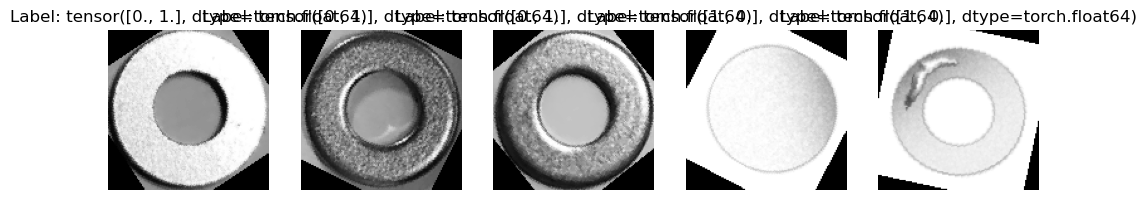

In [43]:
# 데이터셋에서 첫 번째 배치 가져오기
images, labels = next(iter(data_loader))

# 이미지와 라벨을 시각화
fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
for idx, (image, label) in enumerate(zip(images, labels)):
    ax = axes[idx]
    # image tensor를 numpy array로 변환 (C, H, W) -> (H, W, C)
    img = image.numpy().transpose(1, 2, 0)
    ax.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
    ax.axis('off')  # 축 끄기
    ax.set_title(f'Label: {label}')
plt.show()

In [44]:
from torch.utils.data import random_split

# 데이터셋과 데이터로더 설정
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 훈련 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# 테스트 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

이제 학습을 위한 모델 생성

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.2):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.dropout(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, dropout_rate=0.2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, dropout_rate))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x

# ResNet-18 and ResNet-34 with dropout
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, dropout_rate=0.2)

In [21]:
# 모델 정의 (ResNet18)
model = resnet18()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 일반적으로 사용되는 weight decay 값

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2

In [22]:
def validate(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.max(1)[1]).sum().item()
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [45]:
# 학습 루프 설정
num_epochs = 20
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 에포크별 손실 출력
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # 검증
    avg_val_loss, accuracy = validate(model, test_loader, device)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 최적 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_save_path = os.path.join(data_root, 'model', 'resnet18_model.pth')  # 모델 저장 경로
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved Best Model to {model_save_path}")

Epoch [1/20], Train Loss: 0.7241
Validation Loss: 0.9408, Accuracy: 46.25%
Saved Best Model to c:\github\CAPSTONE\model\resnet18_model.pth
Epoch [2/20], Train Loss: 0.6788
Validation Loss: 1.8340, Accuracy: 46.25%
Epoch [3/20], Train Loss: 0.6423
Validation Loss: 2.6262, Accuracy: 47.50%
Saved Best Model to c:\github\CAPSTONE\model\resnet18_model.pth
Epoch [4/20], Train Loss: 0.6411
Validation Loss: 3.7371, Accuracy: 46.25%
Epoch [5/20], Train Loss: 0.6290
Validation Loss: 1.7918, Accuracy: 50.00%
Saved Best Model to c:\github\CAPSTONE\model\resnet18_model.pth
Epoch [6/20], Train Loss: 0.5930
Validation Loss: 0.8902, Accuracy: 57.50%
Saved Best Model to c:\github\CAPSTONE\model\resnet18_model.pth
Epoch [7/20], Train Loss: 0.5970
Validation Loss: 2.4462, Accuracy: 46.25%
Epoch [8/20], Train Loss: 0.6050
Validation Loss: 2.0027, Accuracy: 38.75%
Epoch [9/20], Train Loss: 0.5979
Validation Loss: 0.6484, Accuracy: 66.25%
Saved Best Model to c:\github\CAPSTONE\model\resnet18_model.pth
Epoch

In [46]:
def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3], dropout_rate=0.5)

In [47]:
# 모델 정의 (ResNet34)
model = resnet34()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 일반적으로 사용되는 weight decay 값

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2

In [48]:
# 학습 루프 설정
num_epochs = 20
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 에포크별 손실 출력
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # 검증
    avg_val_loss, accuracy = validate(model, test_loader, device)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 최적 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_save_path = os.path.join(data_root, 'model', 'resnet34_model.pth')  # 모델 저장 경로
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved Best Model to {model_save_path}")

Epoch [1/20], Train Loss: 0.7687
Validation Loss: 18.6650, Accuracy: 55.00%
Saved Best Model to c:\github\CAPSTONE\model\resnet34_model.pth
Epoch [2/20], Train Loss: 0.7439
Validation Loss: 1.0865, Accuracy: 46.25%
Epoch [3/20], Train Loss: 0.7048
Validation Loss: 1.0374, Accuracy: 46.25%
Epoch [4/20], Train Loss: 0.6889
Validation Loss: 0.7179, Accuracy: 60.00%
Saved Best Model to c:\github\CAPSTONE\model\resnet34_model.pth
Epoch [5/20], Train Loss: 0.6850
Validation Loss: 0.9550, Accuracy: 48.75%
Epoch [6/20], Train Loss: 0.6631
Validation Loss: 0.8424, Accuracy: 51.25%
Epoch [7/20], Train Loss: 0.6452
Validation Loss: 0.7461, Accuracy: 56.25%
Epoch [8/20], Train Loss: 0.6686
Validation Loss: 0.7127, Accuracy: 58.75%
Epoch [9/20], Train Loss: 0.6914
Validation Loss: 0.6902, Accuracy: 53.75%
Epoch [10/20], Train Loss: 0.6647
Validation Loss: 0.7012, Accuracy: 51.25%
Epoch [11/20], Train Loss: 0.6770
Validation Loss: 0.6883, Accuracy: 56.25%
Epoch [12/20], Train Loss: 0.6718
Validation

In [49]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1  # 첫 번째 Conv layer의 입력 채널을 1로 설정 (그레이스케일)
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [50]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),  # 128x128 입력을 고려하여 조정
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [51]:
# VGG16 features 구성
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16_features = make_layers(cfg, batch_norm=True)
vgg16_model = VGG(vgg16_features, num_classes=2)  # 클래스 수 조정

In [52]:
# 모델 정의 (VGG16)
model = vgg16_model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 일반적으로 사용되는 weight decay 값

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [55]:
# 학습 루프 설정
num_epochs = 20
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 에포크별 손실 출력
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # 검증
    avg_val_loss, accuracy = validate(model, test_loader, device)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 최적 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_save_path = os.path.join(data_root, 'model', 'vgg16_model.pth')  # 모델 저장 경로
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved Best Model to {model_save_path}")

Epoch [1/20], Train Loss: 0.6968
Validation Loss: 0.6996, Accuracy: 47.50%
Saved Best Model to c:\github\CAPSTONE\model\vgg16_model.pth
Epoch [2/20], Train Loss: 0.6696
Validation Loss: 0.6700, Accuracy: 61.25%
Saved Best Model to c:\github\CAPSTONE\model\vgg16_model.pth
Epoch [3/20], Train Loss: 0.6812
Validation Loss: 0.6969, Accuracy: 48.75%
Epoch [4/20], Train Loss: 0.6728
Validation Loss: 0.6889, Accuracy: 53.75%
Epoch [5/20], Train Loss: 0.6881
Validation Loss: 0.6792, Accuracy: 53.75%
Epoch [6/20], Train Loss: 0.6802
Validation Loss: 0.7166, Accuracy: 45.00%
Epoch [7/20], Train Loss: 0.6800
Validation Loss: 0.6886, Accuracy: 56.25%
Epoch [8/20], Train Loss: 0.6773
Validation Loss: 0.6797, Accuracy: 53.75%
Epoch [9/20], Train Loss: 0.6720
Validation Loss: 0.6584, Accuracy: 68.75%
Saved Best Model to c:\github\CAPSTONE\model\vgg16_model.pth
Epoch [10/20], Train Loss: 0.6624
Validation Loss: 0.6577, Accuracy: 47.50%
Epoch [11/20], Train Loss: 0.6761
Validation Loss: 0.7154, Accurac

In [54]:
# 데이터셋과 데이터로더 설정
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 훈련 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# 테스트 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [34]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True),
    )

class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNet, self).__init__()
        self.features = nn.Sequential(
            conv_bn(1, 32, 2),  # 첫 번째 레이어의 입력 채널을 1로 변경
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [35]:
# 모델 인스턴스 생성
mobile_net_model = MobileNet(num_classes=2)  # 클래스 수를 명시적으로 2로 설정

# 확인
print(mobile_net_model.features[0])

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)


In [36]:
# 모델 정의 (MobileNet)
model = mobile_net_model
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 일반적으로 사용되는 weight decay 값

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(64, 128, kernel_size=

In [40]:
# 학습 루프 설정
num_epochs = 20
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 에포크별 손실 출력
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # 검증
    avg_val_loss, accuracy = validate(model, test_loader, device)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 최적 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_save_path = os.path.join(data_root, 'model', 'mobilenet_model.pth')  # 모델 저장 경로
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved Best Model to {model_save_path}")

Epoch [1/20], Train Loss: 0.2763
Validation Loss: 0.3657, Accuracy: 82.50%
Saved Best Model to c:\github\CAPSTONE\model\mobilenet_model.pth
Epoch [2/20], Train Loss: 0.1947
Validation Loss: 0.4818, Accuracy: 82.50%
Epoch [3/20], Train Loss: 0.2064
Validation Loss: 0.4320, Accuracy: 83.75%
Saved Best Model to c:\github\CAPSTONE\model\mobilenet_model.pth
Epoch [4/20], Train Loss: 0.1888
Validation Loss: 0.4566, Accuracy: 83.75%
Epoch [5/20], Train Loss: 0.1777
Validation Loss: 0.4488, Accuracy: 82.50%
Epoch [6/20], Train Loss: 0.1649
Validation Loss: 0.4586, Accuracy: 83.75%
Epoch [7/20], Train Loss: 0.1436
Validation Loss: 0.6178, Accuracy: 83.75%
Epoch [8/20], Train Loss: 0.1652
Validation Loss: 0.9236, Accuracy: 77.50%
Epoch [9/20], Train Loss: 0.2169
Validation Loss: 0.6046, Accuracy: 82.50%
Epoch [10/20], Train Loss: 0.2313
Validation Loss: 0.4539, Accuracy: 86.25%
Saved Best Model to c:\github\CAPSTONE\model\mobilenet_model.pth
Epoch [11/20], Train Loss: 0.2439
Validation Loss: 0.6

In [46]:
def resnet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, dropout_rate=0.2)

In [47]:
# 모델 정의 (ResNet50)
model = resnet50()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 일반적으로 사용되는 weight decay 값

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(25

In [48]:
# 학습 루프 설정
num_epochs = 20
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 에포크별 손실 출력
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # 검증
    avg_val_loss, accuracy = validate(model, test_loader, device)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # 최적 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_save_path = os.path.join(data_root, 'model', 'resnet50_model.pth')  # 모델 저장 경로
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # 디렉토리가 없으면 생성
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved Best Model to {model_save_path}")

Epoch [1/20], Train Loss: 0.7637
Validation Loss: 1.0653, Accuracy: 46.25%
Saved Best Model to c:\github\CAPSTONE\model\resnet50_model.pth
Epoch [2/20], Train Loss: 0.6783
Validation Loss: 1.1746, Accuracy: 46.25%
Epoch [3/20], Train Loss: 0.6377
Validation Loss: 1.1928, Accuracy: 46.25%
Epoch [4/20], Train Loss: 0.7280
Validation Loss: 0.5974, Accuracy: 66.25%
Saved Best Model to c:\github\CAPSTONE\model\resnet50_model.pth
Epoch [5/20], Train Loss: 0.6638
Validation Loss: 0.5839, Accuracy: 65.00%
Epoch [6/20], Train Loss: 0.6580
Validation Loss: 0.6219, Accuracy: 65.00%
Epoch [7/20], Train Loss: 0.6184
Validation Loss: 0.5335, Accuracy: 75.00%
Saved Best Model to c:\github\CAPSTONE\model\resnet50_model.pth
Epoch [8/20], Train Loss: 0.6027
Validation Loss: 0.7506, Accuracy: 65.00%
Epoch [9/20], Train Loss: 0.6017
Validation Loss: 1.0766, Accuracy: 50.00%
Epoch [10/20], Train Loss: 0.5874
Validation Loss: 0.5269, Accuracy: 73.75%
Epoch [11/20], Train Loss: 0.6178
Validation Loss: 0.7374